<h1><center>ECON 570 Problem Set 2</center></h1>
<h2><center>Causal Inference -- A Selection of Monte Carlo Simulations</center></h2>
<h3><center>April 15, 2022</center></h3>
<h3><center>James Gross</center></h3>
    

In [1]:
import numpy as np
import pandas as pd
import random
import networkx as nx
from matplotlib import pyplot as plt
import statsmodels.api as sm
from statsmodels.tools.eval_measures import rmse
from stargazer.stargazer import Stargazer, LineLocation

#### 1. Simulate a DGP where the outcome of interest depends on a randomly assigned treatment and some observed covariates. 

In the first case, we have a variable of interest as well as some covariates which also affect the outcome. While these are not necessarily confounders, we assume they have an additive relationship. That is, they all have an effect on the outcome variable, and so if we do not control for one we may have a biased treatment effect estimate. For example, say we are investigating the relationship between smoking and healthcare spending in a cross-sectional study. While we might assume smokers spend more on healthcare than nonsmokers, it may also be the case those with more money or other preexisting conditions have higher healthcare spending. If we fail to control for these other covariates, our effect estimates will suffer from omitted variable bias.

First, let's simulate a data-generating process (DGP) using the above scenario. Let variable *x* represent the percentage of smokers in a neighborhood, *b* represent average income in \\$1,000s, and *c* represent an index of other preexisting health conditions from 0-10, with 0 being the most healthy. Assume that all three of these correlate positively with variable *y*, healthcare spending in \\$1,000s. In this case, assume variables *x, b, and c* are **not** correlated.

In [2]:
#Generate Data in a DataFrame

a = .1#constant
b1 = .05#true effect of smoking
b2 = .001#true effect of income
b3 = .1#true effect of other preexisting conditions

random.seed(1994)
temp = []
# sample size
for observation in range(1000):
    temp.append({'Smoking':random.triangular(low=1,high=90,mode=30),
                 'Income':random.triangular(low=20,high=150,mode=50),
                 'Preexisting Conditions':random.triangular(low=.1,high=8,mode=3),
                 'e':random.gauss(mu=0,sigma=.1)})
mc_data = pd.DataFrame(temp)
mc_data['Healthcare Spending'] = a + b1*mc_data['Smoking'] + b2*mc_data['Income'] + b3*mc_data['Preexisting Conditions'] + mc_data['e']
mc_data.to_csv('mc1.csv')
mc_data.head()

,Smoking,Income,Preexisting Conditions,e,Healthcare Spending
0,37.331410,81.853374,4.593302,-0.040843,2.466911
1,30.271323,51.595978,5.853628,0.041826,2.292351
2,71.352920,94.861094,1.044551,-0.203497,3.663466
3,9.209767,60.926921,3.673259,-0.085964,0.902777
4,78.934632,89.338936,2.028227,-0.084592,4.254301


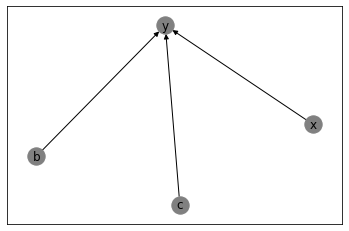

In [3]:
graph = nx.DiGraph()
graph.add_edges_from([("x", "y"), ("b", "y"), ("c", "y")])
nx.draw_networkx(graph, arrows=True, node_color='gray')
plt.savefig("dag1.png", format="PNG")
#https://mungingdata.com/python/dag-directed-acyclic-graph-networkx/

In [4]:
mc_data[['Smoking','Income','Preexisting Conditions','Healthcare Spending']].describe()

,Smoking,Income,Preexisting Conditions,Healthcare Spending
count,1000.000000,1000.000000,1000.000000,1000.000000
mean,40.564956,73.914868,3.652076,2.565753
std,18.575620,28.076819,1.619214,0.933059
min,1.757121,21.833490,0.224249,0.344724
25%,26.533240,51.309822,2.455149,1.873143
50%,38.447148,70.213044,3.481768,2.464036
75%,53.965104,93.898391,4.798469,3.197466
max,88.103609,148.913240,7.759220,5.073083


In [5]:
#build and store models
mc_data_trimmed = mc_data.iloc[0:100]#first hundred
y = mc_data_trimmed['Healthcare Spending']
x = sm.add_constant(mc_data_trimmed[['Smoking']])
result1_a_1 = sm.OLS(y, x).fit()
rmse1 = rmse(y, result1_a_1.predict(x))

y = mc_data['Healthcare Spending']
x = sm.add_constant(mc_data[['Smoking']])
result1_a_2 = sm.OLS(y, x).fit()
rmse2 = rmse(y, result1_a_2.predict(x))

y = mc_data_trimmed['Healthcare Spending']
x = sm.add_constant(mc_data_trimmed[['Smoking','Income','Preexisting Conditions']])
result1_b_1 = sm.OLS(y,x).fit()
rmse3 = rmse(y, result1_b_1.predict(x))

y = mc_data['Healthcare Spending']
x = sm.add_constant(mc_data[['Smoking','Income','Preexisting Conditions']])
result1_b_2 = sm.OLS(y,x).fit()
rmse4 = rmse(y, result1_b_2.predict(x))

In [6]:
#print in stargazer
table = Stargazer([result1_a_1,result1_a_2,result1_b_1,result1_b_2])
table.custom_columns(['N = 100, no covariates','N = 1000, no covariates','N = 100, with covariates','N = 1000, with covariates'], [1,1,1,1])
table.show_model_numbers(False)
table.significant_digits(5)
table.dependent_variable = 'Healthcare Spending in $1,000s'
table.show_degrees_of_freedom(False)
table

In [7]:
#print rmse, treatment effect size, and bias
print('RMSE','\n','N = 100, no covariates: ',rmse1,'\n','N = 1000, no covariates: ',rmse2,'\n',
      'N = 100, with covariates: ',rmse3,'\n','N = 1000, with covariates: ',rmse4)#NOTE: is this rmse of all variables? Should calculate for only smoking??
print('Effect Sizes','\n','N = 100, no covariates: ',result1_a_1.params['Smoking'],'\n','N = 1000, no covariates: ',result1_a_2.params['Smoking'],'\n',
      'N = 100, with covariates: ',result1_b_1.params['Smoking'],'\n','N = 1000, with covariates: ',result1_b_2.params['Smoking'])
print('Bias','\n','N = 100, no covariates: ',b1-result1_a_1.params['Smoking'],'\n','N = 1000, no covariates: ',b1-result1_a_2.params['Smoking'],'\n',
      'N = 100, with covariates: ',b1-result1_b_1.params['Smoking'],'\n','N = 1000, with covariates: ',b1-result1_b_2.params['Smoking'])

RMSE 
 N = 100, no covariates:  0.17805183625505988 
 N = 1000, no covariates:  0.1883844448983667 
 N = 100, with covariates:  0.10323473968412146 
 N = 1000, with covariates:  0.09883233005410712
Effect Sizes 
 N = 100, no covariates:  0.0491602168584504 
 N = 1000, no covariates:  0.04919484706743843 
 N = 100, with covariates:  0.04929562132844985 
 N = 1000, with covariates:  0.04964663374027904
Bias 
 N = 100, no covariates:  0.0008397831415496021 
 N = 1000, no covariates:  0.000805152932561573 
 N = 100, with covariates:  0.0007043786715501543 
 N = 1000, with covariates:  0.0003533662597209608


Without controlling for covariates, we do see a slightly less accurate treatment effect. In this case, the covariates are not correlated with each other, so the univariate regression results are still fairly accurate. However, we do see an increase in performance of the models after including covariates (decreased RMSE, decreased bias).

#### 2. Simulate a DGP with a confounder (common cause)
Next, consider a situation where one of the variables is a confounder. Assume a city official notes that ice cream consumption and murder rates both seem to go up in the summer. However, while there does tend to be a correlation, this is only true insofar as ice cream sale go up when the weather is hot. In this case, let variable *x* indicate ice cream sales per person, variable *b* indicate average temperature in degrees f, and variable *y* indicate the outcome, murders per 100,000 people, each taken at a county-month. If we do not control for the temperature, we will find a positive and significant association between ice cream consumption and murder rates, because we have failed to control for the confounder, temperature. Assume ice cream consumption has no effect on murder rates, and temperature has a .01 effect on murder rate and a .02 effect on ice cream sales.

Similar to the last monte carlo experiment above, I simulate a DGP, produce a DAG, and finally show Monte Carlo results.

In [8]:
#Generate Data in a DataFrame

a = .4#constant
a_x = .1#constant for temperature -> ice cream sales
b1 = 0#true effect of ice cream sales on murder rate
b2 = .01#true effect of temperature on murder rate
b2_x = .02#true effect of temperature on ice cream sales

random.seed(1994)
temp = []
# sample size
for observation in range(1000):
    temp.append({'Average Temperature':random.triangular(low=30,high=90,mode=60),
                 'e':random.gauss(mu=0,sigma=.01),
                 'e_x':random.gauss(mu=0,sigma=.01)})
mc_data = pd.DataFrame(temp)
mc_data['Ice Cream Sales'] = a + b2_x*mc_data['Average Temperature'] + mc_data['e_x']
mc_data['Murder Rate'] = a + b2*mc_data['Average Temperature'] + mc_data['e']
mc_data.to_csv('mc2.csv')

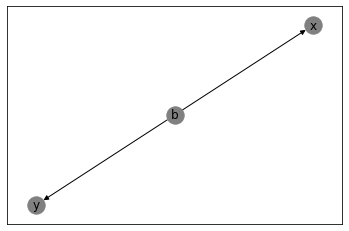

In [9]:
#Produce DAG
graph = nx.DiGraph()
graph.add_edges_from([("b", "y"), ("b", "x")])
nx.draw_networkx(graph, arrows=True, node_color='gray')
plt.savefig("dag2.png", format="PNG")

In [10]:
#build and store models
mc_data_trimmed = mc_data.iloc[0:100]#first hundred
y = mc_data_trimmed['Murder Rate']
x = sm.add_constant(mc_data_trimmed[['Ice Cream Sales']])
result2_a_1 = sm.OLS(y, x).fit()
rmse1 = rmse(y, result2_a_1.predict(x))

y = mc_data['Murder Rate']
x = sm.add_constant(mc_data[['Ice Cream Sales']])
result2_a_2 = sm.OLS(y, x).fit()
rmse2 = rmse(y, result2_a_2.predict(x))

y = mc_data_trimmed['Murder Rate']
x = sm.add_constant(mc_data_trimmed[['Ice Cream Sales','Average Temperature']])
result2_b_1 = sm.OLS(y,x).fit()
rmse3 = rmse(y, result2_b_1.predict(x))

y = mc_data['Murder Rate']
x = sm.add_constant(mc_data[['Ice Cream Sales','Average Temperature']])
result2_b_2 = sm.OLS(y,x).fit()
rmse4 = rmse(y, result2_b_2.predict(x))

In [11]:
#print in stargazer
table = Stargazer([result2_a_1,result2_a_2,result2_b_1,result2_b_2])
table.custom_columns(['N = 100, no covariates','N = 1000, no covariates','N = 100, with covariates','N = 1000, with covariates'], [1,1,1,1])
table.show_model_numbers(False)
table.significant_digits(5)
table.dependent_variable = 'Murder Rate per 100k'
table.show_degrees_of_freedom(False)
table

In [12]:
#print rmse, treatment effect size, and bias
print('RMSE','\n','N = 100, no covariates: ',rmse1,'\n','N = 1000, no covariates: ',rmse2,'\n',
      'N = 100, with covariates: ',rmse3,'\n','N = 1000, with covariates: ',rmse4)
print('Effect Sizes','\n','N = 100, no covariates: ',result2_a_1.params['Ice Cream Sales'],'\n','N = 1000, no covariates: ',result2_a_2.params['Ice Cream Sales'],'\n',
      'N = 100, with covariates: ',result2_b_1.params['Ice Cream Sales'],'\n','N = 1000, with covariates: ',result2_b_2.params['Ice Cream Sales'])
print('Bias','\n','N = 100, no covariates: ',result2_a_1.params['Ice Cream Sales']-b1,'\n','N = 1000, no covariates: ',result2_a_2.params['Ice Cream Sales']-b1,'\n',
      'N = 100, with covariates: ',result2_b_1.params['Ice Cream Sales']-b1,'\n','N = 1000, with covariates: ',result2_b_2.params['Ice Cream Sales']-b1)

RMSE 
 N = 100, no covariates:  0.011208608644424762 
 N = 1000, no covariates:  0.011455741015197514 
 N = 100, with covariates:  0.009753231774839822 
 N = 1000, with covariates:  0.010323884521882177
Effect Sizes 
 N = 100, no covariates:  0.4975319540047104 
 N = 1000, no covariates:  0.49650443832306734 
 N = 100, with covariates:  -0.11203306446602079 
 N = 1000, with covariates:  -0.017534100931215324
Bias 
 N = 100, no covariates:  0.4975319540047104 
 N = 1000, no covariates:  0.49650443832306734 
 N = 100, with covariates:  -0.11203306446602079 
 N = 1000, with covariates:  -0.017534100931215324


In this case, if we were to fail to include the confounder, we might believe the initial hypothesis that ice cream consumption does in fact affect the murder rate. However, when including temperature, we see the treatment effect of ice cream consumption become insignificant and close to zero (the true effect). In this case, RMSE does not change much when correctly specifying the model, since ice cream consumption wrongly shows a similar treatment effect as the true effect of temperature when we fail to control for temperature. However, we see the greatest improvement of bias, which drops from about .5 to about 0.

#### 3. Simulate a DGP with selection bias into the treatment (variable in between the path from the treatment to the outcome)
Finally, consider the following scenario: a manager at a company has been offering to cover the cost of continuing education (CE) hours, and they want to know whether the CE actually results in better performance. However, something like a simple means comparison between those who have CE hours and those who do not will not suffice, because the group who sought to continue their education may be more motivated in the first place. If so, those with more CE hours will have better performance, but we do not know if this is a result of the CE hours or because they are already more motivated. Assume we can have a variable which measures motivation. By controlling for this variable, we can isolate the effect of the CE hours on performance.

Let variable *x* represent CE hours, variable *b* represent motivation on a 1-10 scale, and variable *y* represent the outcome of performance on a 1-10 scale. Assume motivation has an effect of .5 on both CE hours and performance, and CE hours has a .5 effect on performance. I similarly perform the DGP, DAG, and Monte Carlo experiment below.

In [13]:
#Generate Data in a DataFrame

a = 1#constant
a_x = 0#constant for motivation -> CE hours
b1 = .5#true effect of CE hours on performance
b2 = .5#true effect of motivation on performance
b2_x = .5#true effect of motivation on CE hours

random.seed(1994)
temp = []
# sample size
for observation in range(1000):
    temp.append({'Motivation':random.triangular(low=0,high=10,mode=5),
                 'e':random.gauss(mu=0,sigma=.1),
                 'e_x':random.gauss(mu=0,sigma=.1)})
mc_data = pd.DataFrame(temp)
mc_data['CE Hours'] = a + b2_x*mc_data['Motivation'] + mc_data['e_x']
mc_data['Performance'] = a + b1*mc_data['CE Hours'] + b2*mc_data['Motivation'] + mc_data['e']
mc_data.to_csv('mc3.csv')

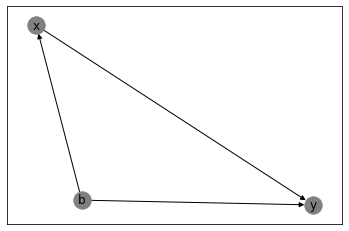

In [14]:
#Produce DAG
graph = nx.DiGraph()
graph.add_edges_from([("b", "x"), ("x", "y"), ("b", "y")])
nx.draw_networkx(graph, arrows=True, node_color='gray')
plt.savefig("dag3.png", format="PNG")

In [15]:
#build and store models
mc_data_trimmed = mc_data.iloc[0:100]#first hundred
y = mc_data_trimmed['Performance']
x = sm.add_constant(mc_data_trimmed[['CE Hours']])
result3_a_1 = sm.OLS(y, x).fit()
rmse1 = rmse(y, result3_a_1.predict(x))

y = mc_data['Performance']
x = sm.add_constant(mc_data[['CE Hours']])
result3_a_2 = sm.OLS(y, x).fit()
rmse2 = rmse(y, result3_a_2.predict(x))

y = mc_data_trimmed['Performance']
x = sm.add_constant(mc_data_trimmed[['CE Hours','Motivation']])
result3_b_1 = sm.OLS(y,x).fit()
rmse3 = rmse(y, result3_b_1.predict(x))

y = mc_data['Performance']
x = sm.add_constant(mc_data[['CE Hours','Motivation']])
result3_b_2 = sm.OLS(y,x).fit()
rmse4 = rmse(y, result3_b_2.predict(x))

In [16]:
#print in stargazer
table = Stargazer([result3_a_1,result3_a_2,result3_b_1,result3_b_2])
table.custom_columns(['N = 100, no covariates','N = 1000, no covariates','N = 100, with covariates','N = 1000, with covariates'], [1,1,1,1])
table.show_model_numbers(False)
table.significant_digits(5)
table.dependent_variable = 'Job Performance (1-10)'
table.show_degrees_of_freedom(False)
table

In [17]:
#print rmse, treatment effect size, and bias
print('RMSE','\n','N = 100, no covariates: ',rmse1,'\n','N = 1000, no covariates: ',rmse2,'\n',
      'N = 100, with covariates: ',rmse3,'\n','N = 1000, with covariates: ',rmse4)
print('Effect Sizes','\n','N = 100, no covariates: ',result3_a_1.params['CE Hours'],'\n','N = 1000, no covariates: ',result3_a_2.params['CE Hours'],'\n',
      'N = 100, with covariates: ',result3_b_1.params['CE Hours'],'\n','N = 1000, with covariates: ',result3_b_2.params['CE Hours'])
print('Bias','\n','N = 100, no covariates: ',result3_a_1.params['CE Hours']-b1,'\n','N = 1000, no covariates: ',result3_a_2.params['CE Hours']-b1,'\n',
      'N = 100, with covariates: ',result3_b_1.params['CE Hours']-b1,'\n','N = 1000, with covariates: ',result3_b_2.params['CE Hours']-b1)

RMSE 
 N = 100, no covariates:  0.13949228206833164 
 N = 1000, no covariates:  0.14166220093202855 
 N = 100, with covariates:  0.09753231774839834 
 N = 1000, with covariates:  0.10323884521882179
Effect Sizes 
 N = 100, no covariates:  1.4849306122256887 
 N = 1000, no covariates:  1.482868613838218 
 N = 100, with covariates:  0.38796693553397654 
 N = 1000, with covariates:  0.48246589906879034
Bias 
 N = 100, no covariates:  0.9849306122256887 
 N = 1000, no covariates:  0.9828686138382181 
 N = 100, with covariates:  -0.11203306446602346 
 N = 1000, with covariates:  -0.017534100931209662


Finally, we can see above that if we did not control for treatment selection bias, we might believe that the effect of CE hours on performance is 3 times as big as it really is. When including the motivation variable, we see a drop in bias of about 1 to almost 0, since both coefficients are near the true values when correctly specifying. We also see an improvement in overall model performance, as RMSE decreases as well.